In [1]:
%display typeset

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math

In [3]:
from sage.calculus.desolvers import desolve_system_rk4

Utilizando dados de Manaus e Vivax:

T1: 27.3
Tmin: 14.5
N: 8557

In [12]:
# Definindo as constantes
num_steps = 50 # Tempo total
dt = 1 # Tamanho do passo

T1 = 23.2  # Temperatura média na ausência de sazonalidade (˚C)
T2 = 0.07  # Amplitude da variabilidade sazonal na temperatura
omega1 = 0.67  # Frequência angular das oscilações sazonais na temperatura (meses^–1)
phi1 = 1.53  # "Phase lag" da variabilidade da temperatura (defasagem de fase)
R1 = 85.9  # Precipitação mensal média na ausência de sazonalidade (mm)
R2 = 0.98  # Amplitude da variabilidade sazonal na precipitação
omega2 = 0.65  # Frequência angular das oscilações sazonais na precipitação (meses^–1)
phi2 = 1.99  # "Phase lag" da variabilidade da precipitação (defasagem de fase)

B_E = 200 # Número de ovos colocados por adulto por oviposição
p_ME = 0.9 # Probabilidade de sobrevivência dos ovos
p_ML = 0.25 # Probabilidade de sobrevivência das larvas
p_MP = 0.75 # Probabilidade de sobrevivência dos pupas
tau_E = 1 # Duração da fase de desenvolvimento dos ovos
tau_P = 1  # Duração da fase de desenvolvimento das pupas
c1 = 0.00554
c2 = -0.06737

D1 = 36.5
b1 = 0.04 # Proporção de picadas de mosquitos suscetíveis em humanos infectados que resultam em infecção
A = -0.03
B = 1.31
C = -4.4
b2 = 0.09 # Proporção de picadas de mosquitos infectados em humanos suscetíveis que resultam em infecção
tau_H = 10 # Período latente de infecção em humanos
DD = 111 # "Degree days" para desenvolvimento do parasita
Tmin = 16 # Temperatura mínima (abaixo dessa temperatura não há desenvolvimento do parasita)
gamma = 1/120 # 1/Duração média da infectividade humana em dias
R_L = 50 # Chuva limite até que os sítios de reprodução sejam eliminados, removendo indivíduos de estágio imaturo

mu = 0.02  # Taxa de mortalidade de mosquitos
N = 1000  # Número total de humanos
M = 10000  # Número total de mosquitos
I_M0 = M  # Número inicial de mosquitos infectados
I_H0 = 10  # Número inicial de humanos infectados
S_H0 = N - I_H0 # Número inicial de pessoas suscetíveis

R_0: 0.004072991671452201
Prevalência de equilíbrio para mosquitos: 17005.742642660996
Prevalência de equilíbrio para humanos: 659175.7810068812


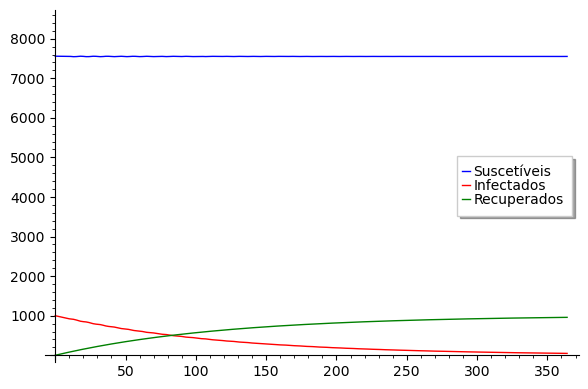

In [11]:
def run_simulation(num_steps=365, dt=1, T1=27.3, T2=0.07, omega1=0.67, phi1=1.53, R1=85.9, R2=0.98, omega2=0.65, phi2=1.99,
                   B_E=200, p_ME=0.9, p_ML=0.25, p_MP=0.75, tau_E=1, tau_P=1, c1=0.00554, c2=-0.06737,
                   D1=36.5, b1=0.04, A=-0.03, B=1.31, C=-4.4, b2=0.09, tau_H=10, DD=105, Tmin=14.5, gamma=1/120, R_L = 50,
                   N=8557, M=10000, I_M0=None, I_H0=1000):
    # Definindo as constantes
    if I_M0 is None:
        I_M0 = M / 100

    S_H0 = N - I_H0

    # Funções de temperatura e chuva
    def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    def tau_L(T):
        return 1 / (c1 * T + c2)

    def p(T):
        return np.exp(-1 / (A*T**2 + B*T + C))
    
    # Probabilidade de sobrevivência das larvas
    def p_L(T):
        return np.exp(-(c1 * T + c2))
    
    def p_L(R):
        return (4*p_ML/R_L**2) * R * (R_L - R)
    
    def p_L(R,T):
        return p_L(T)*p_L(R)

    # Duração do ciclo esporogônico
    def tau_M(T):
        return DD / (T - Tmin)

    # Definindo a função de sobrevivência do mosquito
    def l(tau_M, T):  
        p_T = p(T)
        return p_T**tau_M

    # Definindo a função de mortalidade do mosquito
    def mu(T):
        return -log(p(T))

    # Simulando as equações diferenciais
    S_H = [S_H0]
    I_H = [I_H0]
    R_H = [0]
    times = [0]

    for t in range(1, num_steps):
        # Atualiza a temperatura e a chuva
        T_curr = T(t * dt)
        R_curr = R(t * dt)

        # Calcular a taxa de mordida e probabilidade de transmissão
        a = (T_curr - T1) / D1
        b = B_E * p_ME * p_ML * p_MP / (tau_E + tau_L(T_curr) + tau_P)

        if t < tau_H:
            dS_H = -a * b2 * (I_M0 / N) * S_H[-1]
            dI_H = a * b2 * (I_M0 / N) * S_H[-1] - gamma * I_H[-1]
        else:
            dS_H = -a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H]
            dI_H = a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H] - gamma * I_H[-1]
        dR_H = gamma * I_H[-1]

        # Atualize as populações
        S_H.append(S_H[-1] + dt * dS_H)
        I_H.append(I_H[-1] + dt * dI_H)
        R_H.append(R_H[-1] + dt * dR_H)
        times.append(t * dt)

    # Calculando R_0
    def calculate_R0(M, a, b1, b2, T, gamma, mu, N):
        tau_M_T = tau_M(T)
        l_tau_M = l(tau_M_T, T)  
        R_0 = (M * a**2 * b1 * b2 * l_tau_M) / (gamma * mu(T) * N)
        return R_0

    R_0 = calculate_R0(M, a, b1, b2, T1, gamma, mu, N)
    print(f"R_0: {R_0}")

    # Calcular prevalências de equilíbrio
    I_M_star = M * (R_0 - 1) / ((R_0 / l(DD / (T1 - Tmin), T1)) + (a * b2 * M / (gamma * N)))
    I_H_star = N * (R_0 - 1) / (R_0 + (a * b1 / mu(T1)))

    print(f"Prevalência de equilíbrio para mosquitos: {I_M_star}")
    print(f"Prevalência de equilíbrio para humanos: {I_H_star}")

    times = [i*dt for i in range(num_steps)]

    # Criar os gráficos
    p1 = line(zip(times, S_H), color='blue', legend_label='Suscetíveis')
    p2 = line(zip(times, I_H), color='red', legend_label='Infectados')
    p3 = line(zip(times, R_H), color='green', legend_label='Recuperados')

    # Combinar os gráficos e mostrar o resultado
    (p1 + p2 + p3).show(xmin=0, xmax=num_steps*dt, ymin=0, ymax=N)

# Executar a simulação com os parâmetros padrão
run_simulation()